### **Dependencies**

In [12]:
%matplotlib inline
import os
import sys
import random
sys.path.append('../midi')

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

from google.colab import drive
drive.mount('/content/drive')

myDrive = '/content/drive/My Drive/DeepLearning_2020/Final Project/Music-Generation-master/'

!cp "drive/My Drive/DeepLearning_2020/Final Project/Music-Generation-master/midi/midi_utils.py" .
!cp "drive/My Drive/DeepLearning_2020/Final Project/Music-Generation-master/midi/MidiOutFile.py" .
!cp "drive/My Drive/DeepLearning_2020/Final Project/Music-Generation-master/midi/MidiOutStream.py" .
!cp "drive/My Drive/DeepLearning_2020/Final Project/Music-Generation-master/midi/RawOutstreamFile.py" .
!cp "drive/My Drive/DeepLearning_2020/Final Project/Music-Generation-master/midi/DataTypeConverters.py" .
!cp "drive/My Drive/DeepLearning_2020/Final Project/Music-Generation-master/midi/constants.py" .
!cp "drive/My Drive/DeepLearning_2020/Final Project/Music-Generation-master/midi/MidiInFile.py" .
!cp "drive/My Drive/DeepLearning_2020/Final Project/Music-Generation-master/midi/RawInstreamFile.py" .
!cp "drive/My Drive/DeepLearning_2020/Final Project/Music-Generation-master/midi/MidiFileParser.py" .
!cp "drive/My Drive/DeepLearning_2020/Final Project/Music-Generation-master/midi/EventDispatcher.py" .

from midi_utils import midiread, midiwrite
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import numpy as np
import torch
import torch.utils.data as data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Loader

In [0]:
def midi_filename_to_piano_roll(midi_filename):
    
    midi_data = midiread(midi_filename, dt=0.3)
    
    piano_roll = midi_data.piano_roll.transpose()
    
    # Pressed notes are replaced by 1
    piano_roll[piano_roll > 0] = 1
    
    return piano_roll


def pad_piano_roll(piano_roll, max_length=132333, pad_value=0):
        
    original_piano_roll_length = piano_roll.shape[1]
    
    padded_piano_roll = np.zeros((88, max_length))
    padded_piano_roll[:] = pad_value
    
    padded_piano_roll[:, -original_piano_roll_length:] = piano_roll

    return padded_piano_roll


class NotesGenerationDataset(data.Dataset):
    
    def __init__(self, midi_folder_path, longest_sequence_length=1491):
        
        self.midi_folder_path = midi_folder_path
        
        midi_filenames = os.listdir(midi_folder_path)
        
        self.longest_sequence_length = longest_sequence_length
        
        midi_full_filenames = map(lambda filename: os.path.join(midi_folder_path, filename),midi_filenames)
        
        self.midi_full_filenames = list(midi_full_filenames)
        
        if longest_sequence_length is None:
            
            self.update_the_max_length()
    
    
    def update_the_max_length(self):
        
        sequences_lengths = map(lambda filename: midi_filename_to_piano_roll(filename).shape[1],self.midi_full_filenames)
        
        max_length = max(sequences_lengths)
        
        self.longest_sequence_length = max_length
                
    
    def __len__(self):
        
        return len(self.midi_full_filenames)
    
    def __getitem__(self, index):
        
        midi_full_filename = self.midi_full_filenames[index]
        
        piano_roll = midi_filename_to_piano_roll(midi_full_filename)
        
        # Shifting by one time step
        sequence_length = piano_roll.shape[1] - 1
        
        # Shifting by one time step
        input_sequence = piano_roll[:, :-1]
        ground_truth_sequence = piano_roll[:, 1:]
                
        # padding sequence so that all of them have the same length
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length)
        
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,max_length=self.longest_sequence_length,pad_value=-100)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),torch.LongTensor(ground_truth_sequence_padded),torch.LongTensor([sequence_length]) )

    
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[2]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, list(lengths_batch_sorted_list)

In [0]:
trainset = NotesGenerationDataset(myDrive + 'notebooks/Nottingham/train', longest_sequence_length=None)
trainset_loader = data.DataLoader(trainset, batch_size=8,shuffle=True, drop_last=True)

valset = NotesGenerationDataset(myDrive + 'notebooks/Nottingham/valid', longest_sequence_length=None)
valset_loader = data.DataLoader(valset, batch_size=8, shuffle=False, drop_last=False)

### RNN definition


In [0]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size1)
        
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        
        self.lstm1 = nn.LSTM(hidden_size1, hidden_size2, n_layers)
        self.lstm2 = nn.LSTM(hidden_size2, hidden_size2, n_layers)
        
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        

        self.logits_fc = nn.Linear(hidden_size2, num_classes)
    
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.criterion_val = nn.CrossEntropyLoss().cuda()

        self.loss_list = []
        self.val_list = []
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        notes_encoded_norm = self.bn1(notes_encoded_rolled)
        
        notes_encoded_norm_drop = nn.Dropout(0.25)(notes_encoded_norm)
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        outputs1, hidden1 = self.lstm1(packed, hidden)
        outputs2, hidden2 = self.lstm2(outputs1, hidden1)
        
        
        # Here we unpack sequence(back to padded)
        outputs2, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs2)
        
        outputs_norm = self.bn2(outputs2.permute(1,2,0).contiguous())
        outputs_drop = nn.Dropout(0.1)(outputs_norm)
        logits = self.logits_fc(outputs_drop.permute(2,0,1))
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking,crossentropy is used
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

    def validate(self):
      self.eval()
      full_val_loss = 0.0
      overall_sequence_length = 0.0

      for batch in valset_loader:

          post_processed_batch_tuple = post_process_sequence_batch(batch)

          input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

          output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

          input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

          logits, _ = self(input_sequences_batch_var, sequences_lengths)

          loss = self.criterion_val(logits, output_sequences_batch_var)

          full_val_loss += loss.item()
          overall_sequence_length += sum(sequences_lengths)

      return full_val_loss / (overall_sequence_length * 88)

    def get_triangular_lr(self, lr_low, lr_high, mini_batches):
      iterations = mini_batches
      lr_mid = lr_high/7 + lr_low
      up = np.linspace(lr_low, lr_high, int(round(iterations*0.35)))
      down = np.linspace(lr_high, lr_mid, int(round(iterations*0.35)))
      floor = np.linspace(lr_mid, lr_low, int(round(iterations*0.30)))
      return np.hstack([up, down[1:], floor])


    def train_model(self, trainset_loader, lrs_triangular, path, epochs_number=2, wd=0.0, best_val_loss=float("inf") ):
      clip = 1.0
      self.optimizer = torch.optim.Adam(rnn.parameters(), lr=lrs_triangular[0], weight_decay=wd)
      for epoch_number in range(epochs_number):
          self.train()
          epoch_loss = []
          for lr, batch in zip(lrs_triangular, trainset_loader):
              self.optimizer.param_groups[0]['lr'] = lr

              post_processed_batch_tuple = post_process_sequence_batch(batch)

              input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

              output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

              input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

              self.optimizer.zero_grad()

              logits, _ = self(input_sequences_batch_var, sequences_lengths)

              loss = self.criterion(logits, output_sequences_batch_var)
              epoch_loss.append(loss.item())
              loss.backward()

              torch.nn.utils.clip_grad_norm_(self.parameters(), clip)

              self.optimizer.step()

          current_trn_epoch = sum(epoch_loss)/len(trainset_loader)
          print('Training Loss: Epoch:',epoch_number,':', current_trn_epoch)
          plt.plot(epoch_loss)
          plt.show()
          current_val_loss = self.validate()

          self.loss_list.append(current_trn_epoch)

          self.val_list.append(current_val_loss)

          print('Validation Loss: Epoch:',epoch_number,':', current_val_loss)
          print('')

          if epoch_number % 10 == 0:
              torch.save(self.state_dict(), myDrive + path + '/music_model_epoch_' + str(epoch_number) + '.pth')

          if current_val_loss < best_val_loss:

              torch.save(self.state_dict(), myDrive + path + '/music_model_best_loss.pth')
              best_val_loss = current_val_loss
      
      torch.save(self.state_dict(), myDrive + path + '/music_model_epoch_' + str(epochs_number) + '.pth')

      return best_val_loss

In [0]:
rnn = RNN(input_size=88, hidden_size1=64,hidden_size2=64, num_classes=88, n_layers = 16).cuda()
#rnn.load_state_dict(torch.load(myDrive+ 'notebooks/models/4_hidden_128/music_model_epoch_1000.pth'))
n_epochs = 100
weight_decay = 0.0
lr_low = 1e-4
lr_high = 1e-3  
save_path = 'notebooks/models/Proves'

In [34]:
lrs_triangular = rnn.get_triangular_lr(lr_low, lr_high, len(trainset_loader))
rnn.train_model(trainset_loader, lrs_triangular,save_path,n_epochs, weight_decay )


Output hidden; open in https://colab.research.google.com to view.

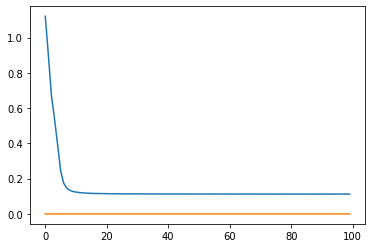

In [35]:
plt.plot(rnn.loss_list)
plt.plot(rnn.val_list)

### Test


In [0]:
def sample_from_piano_rnn(rnn, sample_length=4, temperature=1, starting_sequence=None):
    rnn.eval()
    if starting_sequence is None:
                
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 0
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())
    else:
        current_sequence_input = starting_sequence
        
    final_output_sequence = [current_sequence_input.data.squeeze(1)]

    hidden = None

    for i in range(sample_length):

        output, hidden = rnn(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.div(temperature), dim=1)

        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        current_sequence_input = Variable(current_sequence_input.float())

        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

In [0]:
testset = NotesGenerationDataset( myDrive + 'notebooks/Nottingham/test/', longest_sequence_length=None)

testset_loader = torch.utils.data.DataLoader(testset, batch_size=1,shuffle=True, drop_last=False)

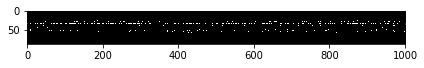

In [44]:
rnn = RNN(input_size=88, hidden_size1=64,hidden_size2=64, num_classes=88, n_layers = 16).cuda()
rnn.load_state_dict(torch.load(myDrive+ 'notebooks/models/32_LSTMS_64/music_model_epoch_100.pth'))

sample = sample_from_piano_rnn(rnn, sample_length=1000, temperature=0.3,starting_sequence=None).transpose()
io.imshow(sample)
midiwrite(myDrive + 'notebooks/sample_reg_018.mid', sample.transpose(), dt=0.3)

### Transfer learning


In [0]:
trainset_transfer = NotesGenerationDataset(myDrive + 'notebooks/BluesMidiClean/train', longest_sequence_length=None)
trainset_loader_transfer = data.DataLoader(trainset, batch_size=4,shuffle=True, drop_last=True)

valset_transfer = NotesGenerationDataset(myDrive + 'notebooks/BluesMidiClean/val', longest_sequence_length=None)
valset_loader_transfer = data.DataLoader(valset, batch_size=4, shuffle=False, drop_last=False)

In [0]:
rnn = RNN(input_size=88, hidden_size1=64, hidden_size2=64, num_classes=88, n_layers = 16).cuda()
rnn.load_state_dict(torch.load(myDrive+ 'notebooks/models/32_LSTMS_64/music_model_epoch_100.pth'))
n_epochs = 100
weight_decay = 0.0
lr_low = 1e-6
lr_high = 1e-4
save_path = 'notebooks/models/ProvaBlues'

In [47]:
lrs_triangular = rnn.get_triangular_lr(lr_low, lr_high, len(trainset_loader))
rnn.train_model(trainset_loader_transfer, lrs_triangular,save_path,n_epochs, weight_decay )


Output hidden; open in https://colab.research.google.com to view.

In [0]:
testset = NotesGenerationDataset( myDrive + 'notebooks/BluesMidiClean/test', longest_sequence_length=None)

testset_loader = torch.utils.data.DataLoader(testset, batch_size=1,shuffle=True, drop_last=False)


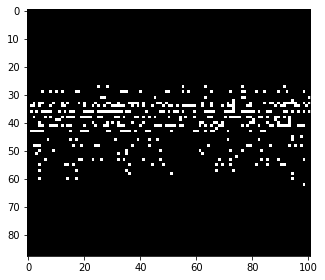

In [54]:
rnn = RNN(input_size=88, hidden_size1=64,hidden_size2=64, num_classes=88, n_layers = 16).cuda()
rnn.load_state_dict(torch.load(myDrive + 'notebooks/models/32_LSTMS_64_transfer/music_model_epoch_100.pth'))

sample = sample_from_piano_rnn(rnn, sample_length=100, temperature=0.5,starting_sequence=None).transpose()
io.imshow(sample)
midiwrite(myDrive + 'notebooks/sample_reg_018_blues.mid', sample.transpose(), dt=0.3)